In [1]:
import os
import pathlib

import numpy as np

from tqdm.notebook import tqdm

#

import torch
import torchvision

import src.datasets.deep_fashion_ctsrbm

In [2]:
from fastervit import create_model

---

In [3]:
model = create_model(
    "faster_vit_0_224",
    pretrained=True
)

/home-net/gortega/fashion_retrieval/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
with open("misc/faster_vit_0_model_arch.txt", "w") as out_file:
    print(model, file=out_file)

---

In [5]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

model.patch_embed.register_forward_hook(get_activation('patch_embed'))

model.levels[0].blocks.register_forward_hook(get_activation('levels[0].blocks'))
model.levels[0].downsample.register_forward_hook(get_activation('levels[0].downsample'))

model.levels[1].blocks.register_forward_hook(get_activation('levels[1].blocks'))
model.levels[1].downsample.register_forward_hook(get_activation('levels[1].downsample'))

model.levels[2].blocks.register_forward_hook(get_activation('levels[2].blocks'))
model.levels[2].downsample.register_forward_hook(get_activation('levels[2].downsample'))
model.levels[2].global_tokenizer.register_forward_hook(get_activation('levels[2].global_tokenizer'))

model.levels[3].blocks.register_forward_hook(get_activation('levels[3].blocks'))

model.norm.register_forward_hook(get_activation('norm'))
model.avgpool.register_forward_hook(get_activation('avgpool'))
model.head.register_forward_hook(get_activation('head'))

In [6]:
input_tensor = torch.rand(1, 3, 224, 224)
output_tensor = model(input_tensor)

In [7]:
print("{:50s} {:}".format("input_tensor", input_tensor.shape))
print("{:50s} {:}".format("output_tensor", output_tensor.shape))

print("---")

for key, item in activation.items():
    print("{:50s} {:}".format(key, item.shape))

input_tensor                                       torch.Size([1, 3, 224, 224])
output_tensor                                      torch.Size([1, 1000])
---
patch_embed                                        torch.Size([1, 64, 56, 56])
levels[0].downsample                               torch.Size([1, 128, 28, 28])
levels[1].downsample                               torch.Size([1, 256, 14, 14])
levels[2].global_tokenizer                         torch.Size([1, 16, 256])
levels[2].downsample                               torch.Size([1, 512, 7, 7])
norm                                               torch.Size([1, 512, 7, 7])
avgpool                                            torch.Size([1, 512, 1, 1])
head                                               torch.Size([1, 1000])


---

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import src.datasets.deep_fashion_ctsrbm

import src.comps.backbones_trf

In [9]:
model = src.comps.backbones_trf.FasterVit0Backbone(
    img_size=224
)

In [10]:
model_image_transform = model.get_image_transform()
ctsrbm_dataset_dir = os.path.join(pathlib.Path.home(), "data", "DeepFashion", "Consumer-to-shop Clothes Retrieval Benchmark")
ctsrbm_dataset = src.datasets.deep_fashion_ctsrbm.ConsToShopClothRetrBmkImageLoader(ctsrbm_dataset_dir, model_image_transform)

In [11]:
last_feature_l = 0
last_feature_hw = 0

for size in tqdm([224]):

    model_input = torch.rand(1, 3, size, size)
    model_output = model(model_input)

    print(model_output.shape)

    feature_l = model_output.size(1)
    feature_hw = model_output.size(3)

    if last_feature_l < feature_l or last_feature_hw < feature_hw:
        print("{:3d} {:3d} {:3d}".format(size, feature_l, feature_hw))
        last_feature_l = feature_l
        last_feature_hw = feature_hw

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 512, 7, 7])
224 512   7


In [12]:
def show_data_ConsToShopClothRetrBmkImageLoader(idx):

    image, item_id = ctsrbm_dataset[idx]

    image_copy = image

    if type(image) == torch.Tensor:
        image_copy = image_copy.permute(1, 2, 0)

    vmax = image_copy.max().item()
    vmin = image_copy.min().item()

    image_copy = (image_copy - vmin) / (vmax - vmin)

    plt.imshow(image_copy)
    
    title_lines = []
    title_lines.append("Image ID: {:d}".format(idx))
    title_lines.append("Item ID: {:d}".format(item_id))
    title_lines.append("Size: " + str(image_copy.size()))
    plt.title("\n".join(title_lines))

    plt.show()

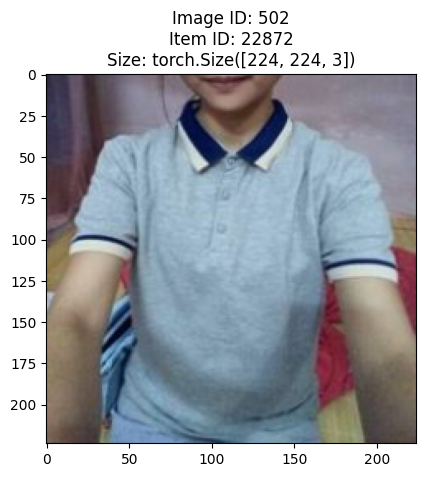

In [13]:
show_data_ConsToShopClothRetrBmkImageLoader(502)